In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.RandomHorizontalFlip(),  
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

#### the dataset doesn't contains train - test splits so we have to do the splits ourselves

In [5]:
dataset = datasets.OxfordIIITPet(root="/kaggle/working/", target_types="category", transform=transform['train'], download=True)

100%|██████████| 791918971/791918971 [00:56<00:00, 13893834.01it/s]


Extracting /kaggle/working/oxford-iiit-pet/images.tar.gz to /kaggle/working/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 6521143.49it/s] 


Extracting /kaggle/working/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/oxford-iiit-pet


#### train - test splits

In [6]:
train_size = int(0.8 * len(dataset)) 
test_size = len(dataset) - train_size 

In [7]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
train_dataset.dataset.transform = transform['train']
test_dataset.dataset.transform = transform['test']

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

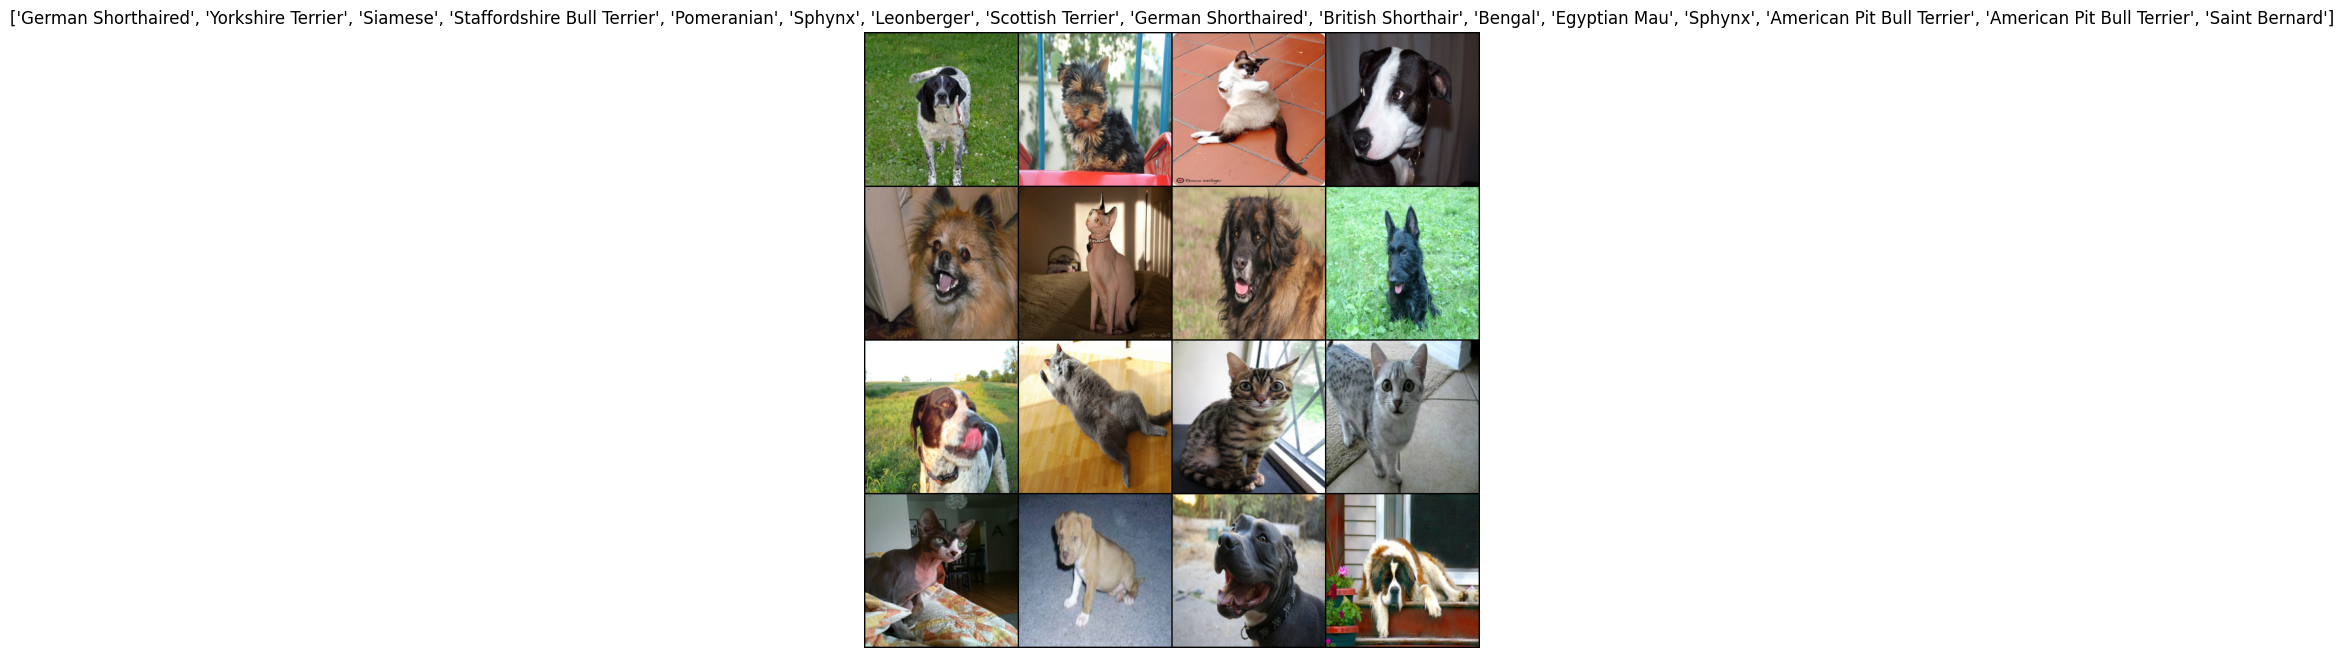

In [10]:
import matplotlib.pyplot as plt

def visualize_dataset(loader):
    images, labels = next(iter(loader))  
    images = images[:16]  
    labels = labels[:16] 

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean 

    grid = torchvision.utils.make_grid(images, nrow=4)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy())  
    plt.title([train_dataset.dataset.classes[label] for label in labels])
    plt.axis('off')
    plt.show()

visualize_dataset(train_loader)

### Making of ResNet 69

#### its just the addition and subtraction of layers from the ResNet50 model and also will be using BasicBlocks to make the residual connections

In [11]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # shortcut connection for dimensional mismatch

    def forward(self, x):
        identity = x  # saving the original input for the residual connection
        if self.downsample is not None:
            identity = self.downsample(x)  # Transform input if dimensions don't match

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # residual connection
        out = self.relu(out)  # apply activation after addition
        return out

In [18]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()

        # initial conv layers
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # the residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    # stacking multiple blocks by creating residual layers
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        # if stride > 1 or channel size changes, adjusting the skip connections
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        # first block
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        # adding the remaining blocks
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [14]:
resnet69 = ResNet(BasicBlock, layers=[3,4,12,3]).to(device)

In [15]:
resnet69

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(resnet69)
print(f"Number of trainable parameters: {total_params}")

Number of trainable parameters: 28881704


In [17]:
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet69.parameters(), lr=5e-4)

#### training

In [19]:
for epoch in range(num_epochs):
    resnet69.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = resnet69(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/30], Loss: 3.8571, Accuracy: 4.86%
Epoch [2/30], Loss: 3.4015, Accuracy: 8.36%
Epoch [3/30], Loss: 3.2741, Accuracy: 10.56%
Epoch [4/30], Loss: 3.1958, Accuracy: 12.81%
Epoch [5/30], Loss: 3.0926, Accuracy: 13.35%
Epoch [6/30], Loss: 2.9993, Accuracy: 15.93%
Epoch [7/30], Loss: 2.9209, Accuracy: 17.36%
Epoch [8/30], Loss: 2.8060, Accuracy: 20.86%
Epoch [9/30], Loss: 2.7336, Accuracy: 21.84%
Epoch [10/30], Loss: 2.6269, Accuracy: 24.73%
Epoch [11/30], Loss: 2.5308, Accuracy: 27.34%
Epoch [12/30], Loss: 2.4282, Accuracy: 29.82%
Epoch [13/30], Loss: 2.3423, Accuracy: 32.40%
Epoch [14/30], Loss: 2.2183, Accuracy: 34.75%
Epoch [15/30], Loss: 2.0991, Accuracy: 37.57%
Epoch [16/30], Loss: 1.9874, Accuracy: 39.64%
Epoch [17/30], Loss: 1.8574, Accuracy: 43.75%
Epoch [18/30], Loss: 1.7551, Accuracy: 45.41%
Epoch [19/30], Loss: 1.6248, Accuracy: 50.41%
Epoch [20/30], Loss: 1.4575, Accuracy: 54.93%
Epoch [21/30], Loss: 1.3288, Accuracy: 58.46%
Epoch [22/30], Loss: 1.1665, Accuracy: 62.67%

#### test

In [20]:
resnet69.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet69(images)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 38.32%


#### seeing the model results

In [24]:
def visualize_test_results(model, test_loader, classes, device, num_images=8):

    model.eval()  
    images_shown = 0

    plt.figure(figsize=(12, 6))
    with torch.no_grad():  # disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                # unnormalize the image for display
                image = images[i].cpu().numpy().transpose(1, 2, 0)  # convert to (H, W, C)
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                image = image * std + mean  
                image = np.clip(image, 0, 1)  

                plt.subplot(2, num_images // 2, images_shown + 1)
                plt.imshow(image)
                plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}", color="green" if preds[i] == labels[i] else "red")
                plt.axis("off")

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

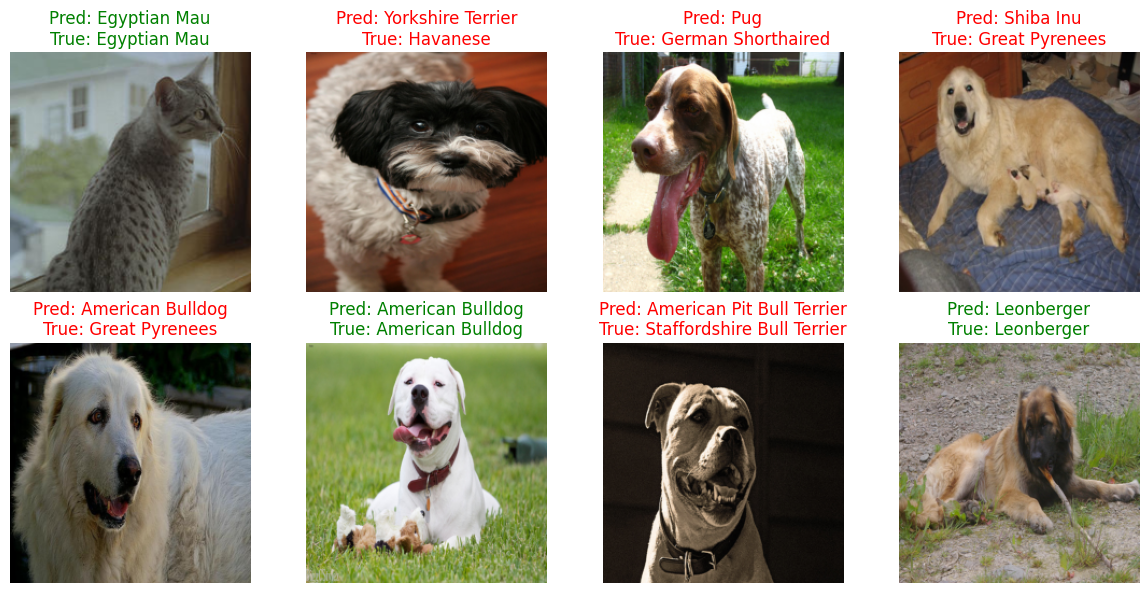

In [25]:
visualize_test_results(resnet69, test_loader, test_dataset.dataset.classes, device)